[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/francisco-ortin/data-science-course/blob/main/classification/decision_tree.ipynb)
[![License: CC BY-NC-SA 4.0](https://img.shields.io/badge/License-CC%20BY--NC--SA%204.0-lightgrey.svg)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

# Decision tree

This notebook contains questions and exercises about decision trees. We will use the [Titanic Disaster dataset](https://www.kaggle.com/c/titanic/data?select=test.csv) stored in `data/titanic.csv`.The dataset has de following features:
- PassengerId: unique identifier for each passenger.
- Survived: target variable (0 = No, 1 = Yes).
- Pclass: ticket class (1 = 1st, 2 = 2nd, 3 = 3rd).
- Name: name of the passenger.
- Sex: "male" or "female".
- Age: age in years.
- SibSp: number of siblings/spouses aboard.
- Parch: number of parents/children aboard.
- Ticket: ticket number.
- Fare: passenger fare.
- Cabin: cabin number.
- Embarked: port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton).


In [108]:
# make sure the required packages are installed
%pip install pandas seaborn matplotlib scikit-learn --quiet
repo='data-science-course'
module='classification'
# if running in colab, install the required packages and copy the necessary files
if get_ipython().__class__.__module__.startswith('google.colab'):
    import os
    if not os.path.exists(repo):
        !git clone --filter=blob:none --sparse https://github.com/francisco-ortin/data-science-course.git  2>/dev/null
        !cd {repo} && git sparse-checkout init --cone && git sparse-checkout set {module}  2>/dev/null
    !cp --update {repo}/{module}/*.py . 2>/dev/null
    !mkdir -p img data
    !mv {repo}/{module}/img/* img/.  2>/dev/null
    !mv {repo}/{module}/data/* data/.  2>/dev/null

# import the required modules
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score

import utils

random_state = 42
pd.set_option('display.max_columns', None)  # Display all columns of a DataFrame in pandas


Note: you may need to restart the kernel to use updated packages.


## ✨ Questions ✨

1. What features should not be used to train the model? Why?
2. What features should be transformed? Why?
3. How should they be transformed?
4. What features should be scaled? Why?
5. Embarked has missing values, what should we do?
6. Is there any feature engineering that could be done? (you do not need to do it; just describe it)

### Answers

*Write your answers here.*



## Dataset

First, we load the dataset and remove duplicate samples.

In [109]:
# Load the dataset
dataset_file_name = 'data/titanic.csv'
original_dataset = pd.read_csv(dataset_file_name)
print(f"Number of samples in the original dataset: {(n_samples_with_duplicates := len(original_dataset))}.")
# Remove duplicate samples
original_dataset.drop_duplicates(inplace=True)  # inplace applies the changes directly on the DataFrame
print(f"There were {n_samples_with_duplicates - len(original_dataset)} duplicates in the dataset.")

Number of samples in the original dataset: 895.
There were 4 duplicates in the dataset.


We define the metadata of the dataset we will use.

In [110]:
independent_vars = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Age', 'Embarked']
dependent_var = 'Survived'
class_names = ['Not Survived', 'Survived']

We now load the dataset and filter the features to be used.

In [111]:
# Filter out the features that are not going to be used
dataset = original_dataset[independent_vars + [dependent_var]]
print("Filtered dataset:")
print(dataset.head(5), end='\n\n')

Filtered dataset:
   Pclass     Sex  SibSp  Parch     Fare   Age Embarked  Survived
0       3    male      1      0   7.2500  22.0        S         0
1       1  female      1      0  71.2833  38.0        C         1
2       3  female      0      0   7.9250  26.0        S         1
3       1  female      1      0  53.1000  35.0        S         1
4       3    male      0      0   8.0500  35.0        S         0


Transform the categorical features into numerical features.

In [112]:
# Convert the dataset so that, for the Sex feature, 'male' = 1 and 'female' = 0
pd.options.mode.chained_assignment = None  # to avoid the following false warning
dataset['Sex'] = dataset['Sex'].map({'male': 1, 'female': 0})
# Convert the 'Embarked' feature to one-hot encoding
dataset = pd.get_dummies(dataset, columns=['Embarked'])
print("Transformed dataset:")
print(dataset.head(5), end='\n\n')
# Update the independent variables from the dataset
independent_vars = dataset.columns[dataset.columns != dependent_var]

Transformed dataset:
   Pclass  Sex  SibSp  Parch     Fare   Age  Survived  Embarked_C  Embarked_Q  \
0       3    1      1      0   7.2500  22.0         0       False       False   
1       1    0      1      0  71.2833  38.0         1        True       False   
2       3    0      0      0   7.9250  26.0         1       False       False   
3       1    0      1      0  53.1000  35.0         1       False       False   
4       3    1      0      0   8.0500  35.0         0       False       False   

   Embarked_S  
0        True  
1       False  
2        True  
3        True  
4        True  


## Decision tree for data mining

We are going to create a decision tree classifier with the whole dataset. In this case, we do not want to predict the target (machine learning). We want to understand the data (data mining). Decision trees are a good tool for this purpose because they are interpretable.

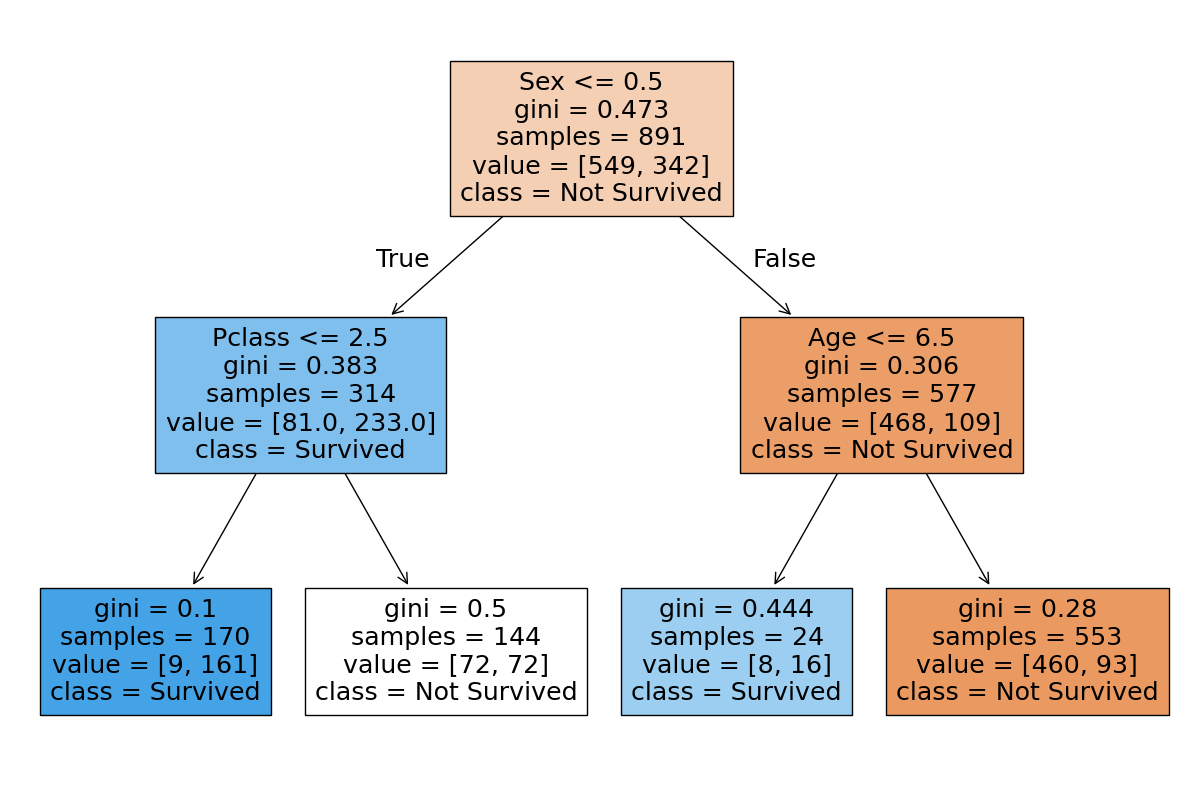

In [113]:
# Let's create a decision tree with maximum depth 2
model = DecisionTreeClassifier(max_depth=2, random_state=random_state)
# we train the model
model.fit(dataset[independent_vars], dataset[dependent_var])
# Now, we visualize the decision tree
# Take time to analyze the tree and understand the decisions made by the algorithm.
# All the fields in the nodes must be understood.
utils.visualize_decision_tree(model, independent_vars, class_names)

## ✨ Questions ✨

7. Is the dataset balanced?
8. What is the most influential feature on the survival?
9. What are the other most influential features?
10. There are decision rules that can be extracted from the tree. For example: "if $<condition>$ then survived = 1". 
Write all of them.

### Answers

*Write your answers here.*



## Decision tree for machine learning

Now, we are going to create a decision tree classifier to predict the survival of the passengers (as a classifier).

In [114]:
# Split the dataset into training and testing sets
(X_train, y_train), (X_test, y_test) = utils.split_dataset(dataset, independent_vars,
                                                           dependent_var, 0.2, random_state)
# Create and train the model
model = DecisionTreeClassifier(random_state=random_state, max_depth=2)
model.fit(X_train, y_train)
# Evaluate the model
y_pred = model.predict(X_test)
accuracy_value = accuracy_score(y_test, y_pred)
f1_score_value = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy_value:.2f}.\nF1 Score: {f1_score_value:.2f}.")

Accuracy: 0.77.
F1 Score: 0.64.


## ✨ Questions ✨

11. What score is higher? Why?
12. Does it make sense to compute AUC-ROC using the model?

### Answers

*Write your answers here.*



### Different max depths

We are going to train the model with different max depths and compare the results. Max depth is one of the most important hyperparameters of decision trees. It controls the maximum depth of the tree. 

In [115]:
# create a validation set from train 
(X_train, y_train), (X_val, y_val) = utils.split_dataset(pd.concat([X_train, y_train], axis=1), 
                                                         independent_vars, dependent_var, 0.3, random_state)
# Create and train different models with different max depths
print("Creating decision trees with different max depths:")
for max_depth in [1, 4, 20]:
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)
    model.fit(X_train, y_train)
    # Evaluate the models
    y_pred = model.predict(X_val)
    accuracy_value = accuracy_score(y_val, y_pred)
    f1_score_value = f1_score(y_val, y_pred)
    print(f"\tMax Depth: {max_depth}. Accuracy: {accuracy_value:.2f}. F1 Score: {f1_score_value:.2f}.")

Creating decision trees with different max depths:
	Max Depth: 1. Accuracy: 0.81. F1 Score: 0.72.
	Max Depth: 4. Accuracy: 0.85. F1 Score: 0.78.
	Max Depth: 20. Accuracy: 0.79. F1 Score: 0.71.


## ✨ Questions ✨

13. What happens when the max depth is 1? Why?
14. What happens when the max depth is 4? Why?
15. What happens when the max depth is 20? Why?
16. How would you choose the best max depth?

### Answers

*Write your answers here.*

